# Ollama Test 
## Categorize Expense Data

https://github.com/thu-vu92/local-llms-analyse-finance/blob/main/categorize_expenses.ipynb

### Test the LLM

In [21]:
#!pip3 install langchain_community

In [22]:
from langchain_community.llms import Ollama

In [23]:
llm = Ollama(model="openchat:7b")
llm.invoke("what country is the krabi province in?")

' The Krabi Province is in Thailand.'

### Import Data

In [24]:
# Read the transactions_2022_2023.csv file 
import pandas as pd
df = pd.read_csv("transactions_2022_2023.csv")
df.head()

,Date,Name / Description,Expense/Income,Amount (EUR)
0,2023-12-30,Belastingdienst,Expense,9.96
1,2023-12-30,Tesco Breda,Expense,17.53
2,2023-12-30,Monthly Appartment Rent,Expense,451.00
3,2023-12-30,Vishandel Sier Amsterdam,Expense,12.46
4,2023-12-29,Selling Paintings,Income,13.63


In [25]:
# Get unique transactions in the Name / Description column
unique_transactions = df["Name / Description"].unique()
len(unique_transactions)

23

In [26]:
unique_transactions[1:10]

array(['Tesco Breda', 'Monthly Appartment Rent',
       'Vishandel Sier Amsterdam', 'Selling Paintings',
       'Spotify Ab By Adyen', 'Tk Maxx Amsterdam Da', 'Consulting',
       'Aidsfonds', 'Tls Bv Inz Ov-Chipkaart'], dtype=object)

### Categorize Transection with LLM

In [27]:
# Get index list
#https://stackoverflow.com/questions/47518609/for-loop-range-and-interval-how-to-include-last-step
def hop(start, stop, step):
    for i in range(start, stop, step):
        yield i
    yield stop

index_list = list(hop(0, len(unique_transactions), 10))
index_list

[0, 10, 20, 23]

In [28]:
def categorize_transactions(transaction_names, llm):
    response = llm.invoke("Can you add an appropriate category to the following expenses. For example: Spotify AB by Adyen - Entertainment, Beta Boulders Ams Amsterdam Nld - Sport, etc.. Categories should be less than 4 words. " + transaction_names)
    response = response.split('\n')

    print(response)

    # Put in dataframe
    categories_df = pd.DataFrame({'Transaction vs category': response})
    categories_df[['Transaction', 'Category']] = categories_df['Transaction vs category'].str.split(' - ', expand=True)
    
    return categories_df

In [29]:
# Test out the function
categorize_transactions('ISS Catering Services De Meern, Taxi Utrecht, Etos AMSTERDAM NLD, Bistro Bar Amsterdam',
                        llm)

[' Sure, here are the categories for each expense:', '', '1. Spotify AB by Adyen - Entertainment', '2. Beta Boulders Ams Amsterdam Nld - Sport', '3. ISS Catering Services De Meern - Food & Beverage', '4. Taxi Utrecht - Transportation', '5. Etos AMSTERDAM NLD - Retail', '6. Bistro Bar Amsterdam - Dining']


,Transaction vs category,Transaction,Category
0,"Sure, here are the categories for each expense:","Sure, here are the categories for each expense:",None
1,,,None
2,1. Spotify AB by Adyen - Entertainment,1. Spotify AB by Adyen,Entertainment
3,2. Beta Boulders Ams Amsterdam Nld - Sport,2. Beta Boulders Ams Amsterdam Nld,Sport
4,3. ISS Catering Services De Meern - Food & Bev...,3. ISS Catering Services De Meern,Food & Beverage
5,4. Taxi Utrecht - Transportation,4. Taxi Utrecht,Transportation
6,5. Etos AMSTERDAM NLD - Retail,5. Etos AMSTERDAM NLD,Retail
7,6. Bistro Bar Amsterdam - Dining,6. Bistro Bar Amsterdam,Dining


In [30]:
# Intialise the categories_df_all dataframe
categories_df_all = pd.DataFrame()

# Loop through the index_list
for i in range(0, len(index_list)-1):
    transaction_names = unique_transactions[index_list[i]:index_list[i+1]]
    transaction_names = ','.join(transaction_names)

    categories_df = categorize_transactions(transaction_names, llm)
    categories_df_all = pd.concat([categories_df_all, categories_df], ignore_index=True)

[' Belastingdienst - Taxes', 'Tesco Breda - Groceries', 'Monthly Apartment Rent - Housing', 'Vishandel Sier Amsterdam - Fish Market', 'Selling Paintings - Art Sales', 'Spotify Ab By Adyen - Entertainment Subscription', 'Tk Maxx Amsterdam Da - Retail Shopping', 'Consulting - Services', 'Aidsfonds - Nonprofit', 'Tls Bv Inz Ov-Chipkaart - Transportation']
[' Here are the categorized expenses:', '', '1. Spotify AB by Adyen - Entertainment', '2. Beta Boulders Ams Amsterdam Nld - Sport', '3. Salary', '4. Bouldermuur Bv Amsterdam - Business', '5. Birtat Restaurant Amsterdam - Food', '6. Freelancing', '7. Tikkie - Payment', '8. Blogging', '9. Taxi Utrecht - Transportation', '10. Apple Services - Technology']
[' Spotify AB by Adyen - Entertainment', 'Beta Boulders Ams Amsterdam Nld - Sport', 'Amazon Lux - Luxury', 'Classpass* Monthly - Fitness', 'Audible UK AdblCo/Pymt Gbr - Audio Books']


In [31]:
categories_df_all

,Transaction vs category,Transaction,Category
0,Belastingdienst - Taxes,Belastingdienst,Taxes
1,Tesco Breda - Groceries,Tesco Breda,Groceries
2,Monthly Apartment Rent - Housing,Monthly Apartment Rent,Housing
3,Vishandel Sier Amsterdam - Fish Market,Vishandel Sier Amsterdam,Fish Market
4,Selling Paintings - Art Sales,Selling Paintings,Art Sales
5,Spotify Ab By Adyen - Entertainment Subscription,Spotify Ab By Adyen,Entertainment Subscription
6,Tk Maxx Amsterdam Da - Retail Shopping,Tk Maxx Amsterdam Da,Retail Shopping
7,Consulting - Services,Consulting,Services
8,Aidsfonds - Nonprofit,Aidsfonds,Nonprofit
9,Tls Bv Inz Ov-Chipkaart - Transportation,Tls Bv Inz Ov-Chipkaart,Transportation


In [32]:
# Get unique categories in categories_df_all
unique_categories = categories_df_all["Category"].unique()
unique_categories

array(['Taxes', 'Groceries', 'Housing', 'Fish Market', 'Art Sales',
       'Entertainment Subscription', 'Retail Shopping', 'Services',
       'Nonprofit', 'Transportation', None, 'Entertainment', 'Sport',
       'Business', 'Food', 'Payment', 'Technology', 'Luxury', 'Fitness',
       'Audio Books'], dtype=object)

In [33]:
# Drop NA values
categories_df_all = categories_df_all.dropna()

In [34]:
categories_df_all

,Transaction vs category,Transaction,Category
0,Belastingdienst - Taxes,Belastingdienst,Taxes
1,Tesco Breda - Groceries,Tesco Breda,Groceries
2,Monthly Apartment Rent - Housing,Monthly Apartment Rent,Housing
3,Vishandel Sier Amsterdam - Fish Market,Vishandel Sier Amsterdam,Fish Market
4,Selling Paintings - Art Sales,Selling Paintings,Art Sales
5,Spotify Ab By Adyen - Entertainment Subscription,Spotify Ab By Adyen,Entertainment Subscription
6,Tk Maxx Amsterdam Da - Retail Shopping,Tk Maxx Amsterdam Da,Retail Shopping
7,Consulting - Services,Consulting,Services
8,Aidsfonds - Nonprofit,Aidsfonds,Nonprofit
9,Tls Bv Inz Ov-Chipkaart - Transportation,Tls Bv Inz Ov-Chipkaart,Transportation


In [35]:
# Remove the numbering eg "1. " from Transaction column
categories_df_all['Transaction'] = categories_df_all['Transaction'].str.replace(r'\d+\.\s+', '', regex=True)
categories_df_all

/var/folders/sy/4k3fghsx7sx6thd5dw0l7l4m0000gn/T/ipykernel_18970/3959838756.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categories_df_all['Transaction'] = categories_df_all['Transaction'].str.replace(r'\d+\.\s+', '', regex=True)


,Transaction vs category,Transaction,Category
0,Belastingdienst - Taxes,Belastingdienst,Taxes
1,Tesco Breda - Groceries,Tesco Breda,Groceries
2,Monthly Apartment Rent - Housing,Monthly Apartment Rent,Housing
3,Vishandel Sier Amsterdam - Fish Market,Vishandel Sier Amsterdam,Fish Market
4,Selling Paintings - Art Sales,Selling Paintings,Art Sales
5,Spotify Ab By Adyen - Entertainment Subscription,Spotify Ab By Adyen,Entertainment Subscription
6,Tk Maxx Amsterdam Da - Retail Shopping,Tk Maxx Amsterdam Da,Retail Shopping
7,Consulting - Services,Consulting,Services
8,Aidsfonds - Nonprofit,Aidsfonds,Nonprofit
9,Tls Bv Inz Ov-Chipkaart - Transportation,Tls Bv Inz Ov-Chipkaart,Transportation


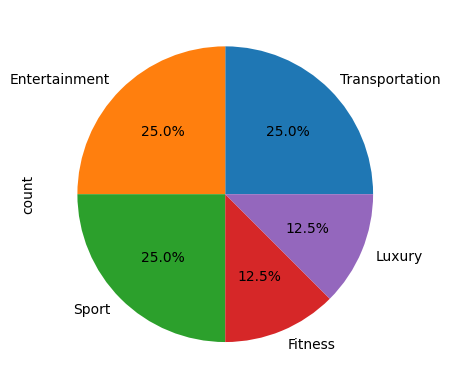

In [44]:
# Plot the top 5 categories in pie chart of the categories_df_all dataframe
categories_df_all['Category'].value_counts().head(5).plot.pie(autopct='%1.1f%%')

import matplotlib.pyplot as plt

